<h1 align="center"><a href="https://github.com/sborquez/gerumo/">*</a> GeRUMo - Gamma-ray Events Reconstructor with Uncertain models</h1>

<h2 align="center">Dataset Explorer</h2>

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2f/Cta_concept.jpg" width="30%" alt="icon"></img>
</center>

## Setup

The first step is to sync this notebook with Google Drive, and change directory to gerumo repository.

#### Colab Setup

In [ ]:
!pip install -q ctaplot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd "/content/drive/My Drive/Projects/gerumo"
!ls

#### Local Setup

In [1]:
%cd D:\sebas\Google Drive\Projects\gerumo

D:\sebas\Google Drive\Projects\gerumo


## Load Gerumo and extra modules.

In [16]:
from gerumo import *

import logging
import time
from os import path
import tables
import numpy as np
import pandas as pd
import uuid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.core.display import display, HTML
import pprint

# ML* Dataset Structure

In [3]:
hdf5_filepath = "D:/sebas/Datasets/gerumo/ML1/gamma_20deg_0deg_srun958-4920___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5"
version = "ML1" # or "ML2"

In [21]:
hdf5_file = tables.open_file(hdf5_filepath, "r")
source = path.basename(hdf5_filepath)
folder = path.dirname(hdf5_filepath)

## Tables and Columns

In [5]:
print(*hdf5_file.root, sep="\n")

/Array_Info (Table(289,)) 'Table of array data'
/Event_Info (Table(1189,)) 'Table of Events'
/LST (Table(552,)) 'Table of LST images'
/MSTF (Table(2277,)) 'Table of MSTF images'
/MSTN (Table(2599,)) 'Table of MSTN images'
/MSTS (Table(1939,)) 'Table of MSTS images'
/SST1 (Table(1358,)) 'Table of SST1 images'
/SSTA (Table(1389,)) 'Table of SSTA images'
/SSTC (Table(1396,)) 'Table of SSTC images'
/Telescope_Info (Table(7,)) 'Table of telescope data'


## Array Info

In [6]:
from gerumo.data.io import _array_info_table, _telescope_attributes

In [7]:
array_info = hdf5_file.root[_array_info_table[version]]
array_info

/Array_Info (Table(289,)) 'Table of array data'
  description := {
  "run_array_direction": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "tel_id": UInt8Col(shape=(), dflt=0, pos=1),
  "tel_type": StringCol(itemsize=8, shape=(), dflt=b'', pos=2),
  "tel_x": Float32Col(shape=(), dflt=0.0, pos=3),
  "tel_y": Float32Col(shape=(), dflt=0.0, pos=4),
  "tel_z": Float32Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (2259,)

In [8]:
# Array data
array_data = {}
# Telescopes Ids
real_telescopes_id = {}
for telescope in hdf5_file.root[_array_info_table[version]]:
    telescope_type = telescope[_telescope_attributes[version]["type"]]
    telescope_type = telescope_type.decode("utf-8") if isinstance(telescope_type, bytes) else telescope_type
    telescope_id = telescope[_telescope_attributes[version]["telescope_id"]]
    if telescope_type not in array_data:
        array_data[telescope_type] = {}
        real_telescopes_id[telescope_type] = []

    array_data[telescope_type][telescope_id] = {
        "id": telescope_id,
        "x": telescope[_telescope_attributes[version]["x"]],
        "y": telescope[_telescope_attributes[version]["y"]],
        "z": telescope[_telescope_attributes[version]["z"]],
    }
    real_telescopes_id[telescope_type].append(telescope_id)

In [9]:
print("Telescopes:", *real_telescopes_id.keys())
print("Types:", len(real_telescopes_id))
print("Per type:", *[ f"{k}:\t{len(v)}" for k,v in real_telescopes_id.items()], sep="\n\t" )

Telescopes: SSTA SSTC MSTF MSTN LST MSTS SST1
Types: 7
Per type:
	SSTA:	70
	SSTC:	70
	MSTF:	25
	MSTN:	25
	LST:	4
	MSTS:	25
	SST1:	70


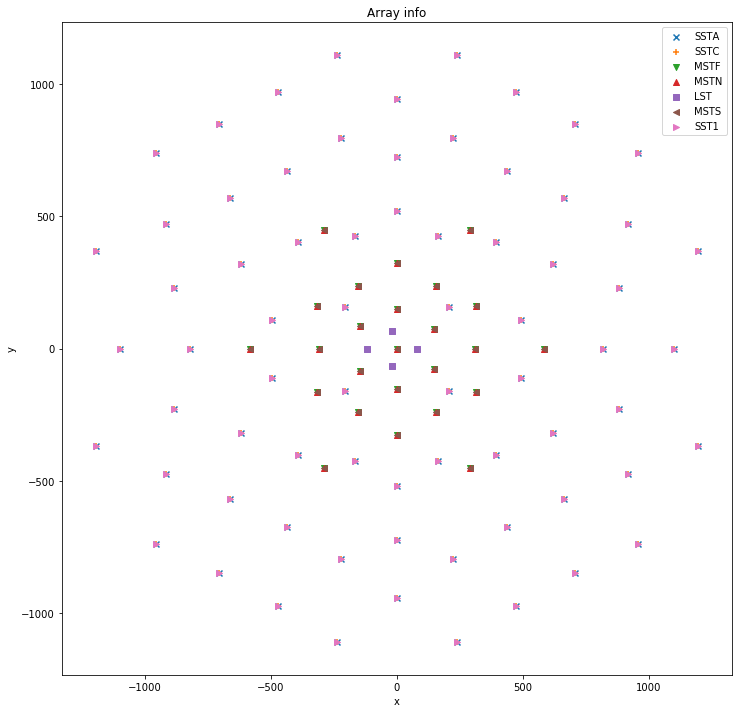

In [10]:
plot_array(array_data)

# Telescope Table

In [31]:
from gerumo.data.io import _telescope_table, _telescopes_info_attributes

In [32]:
telescopes_info = hdf5_file.root[_telescope_table[version]]
telescopes_info

/Telescope_Info (Table(7,)) 'Table of telescope data'
  description := {
  "num_pixels": UInt32Col(shape=(), dflt=0, pos=0),
  "tel_type": StringCol(itemsize=8, shape=(), dflt=b'', pos=1),
  "pixel_pos": Float32Col(shape=(2, 11328), dflt=0.0, pos=2)}
  byteorder := 'little'
  chunkshape := (2,)

In [52]:
_telescopes_info_attributes = {
    "ML1": {
        "num_pixels":   "num_pixels",
        "type":         "tel_type",
        "pixel_pos":    "pixel_pos",
    },
    "ML2": {
        ...
    }
}

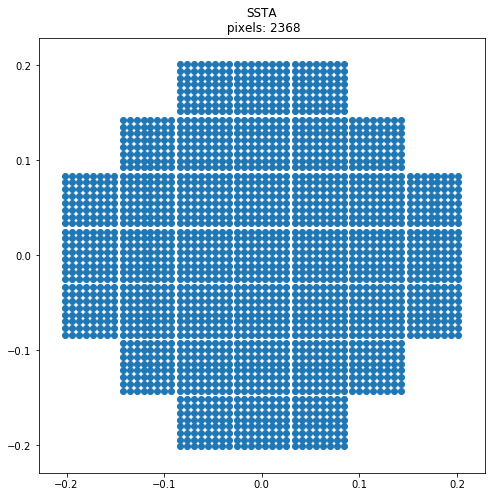

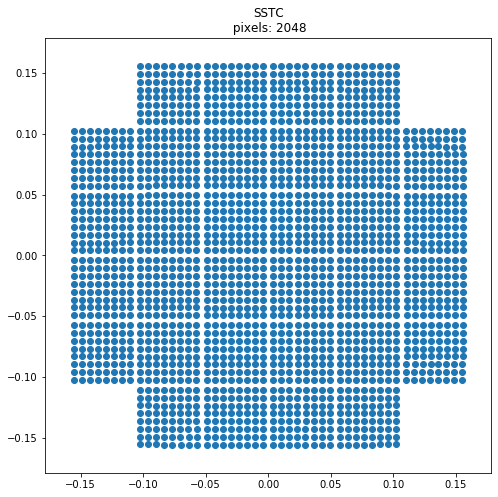

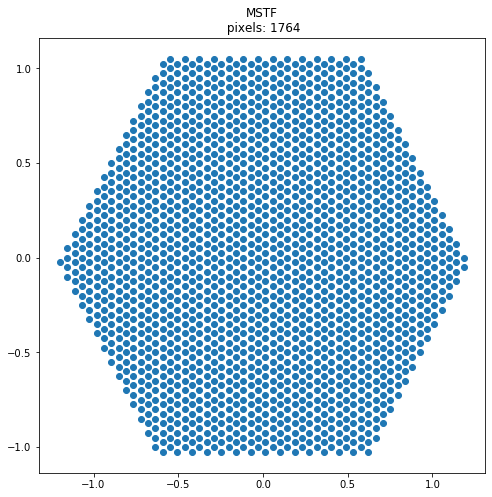

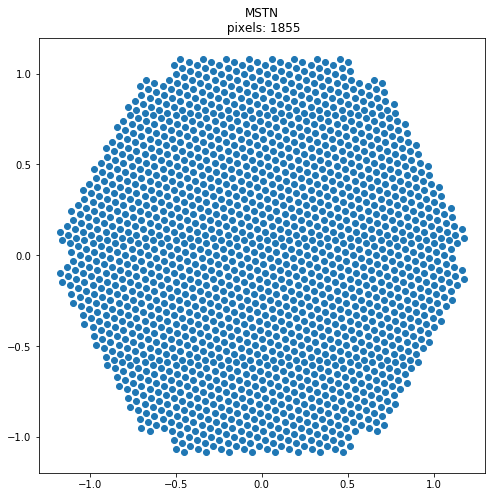

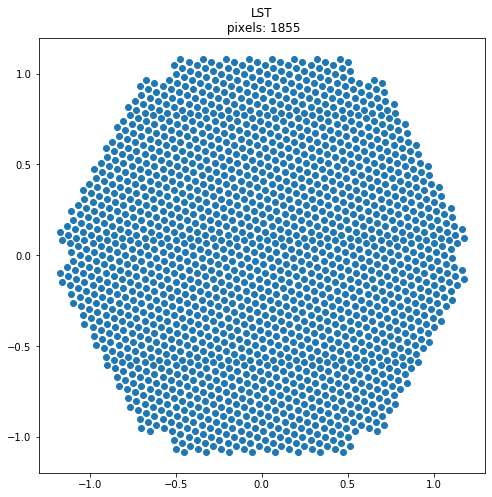

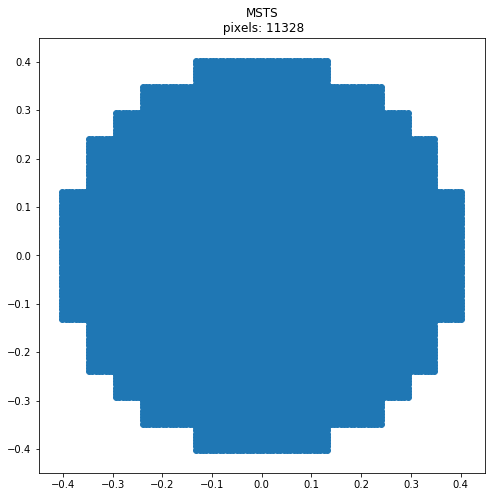

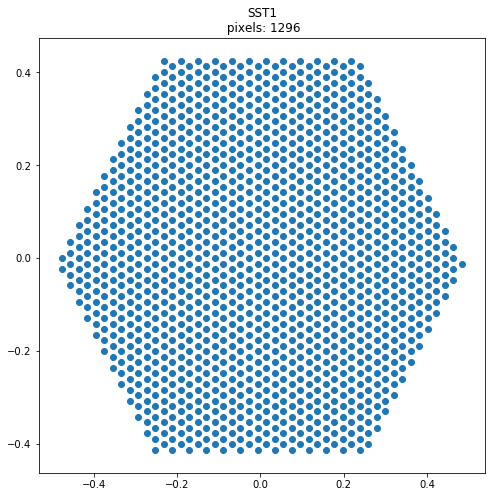

In [71]:
raw_pixpos = {}
for telescope in telescopes_info:
    type_ = telescope[_telescopes_info_attributes[version]["type"]].decode("utf-8")
    num_pixels = telescope[_telescopes_info_attributes[version]["num_pixels"]]
    raw_pixpos[type_] = telescope[_telescopes_info_attributes[version]["pixel_pos"]][:, :num_pixels]
    plot_telescope_geometry(type_, num_pixels, raw_pixpos[type_])

## Event Table

In [12]:
from gerumo.data.io import _events_table

In [15]:
events_info = hdf5_file.root[_events_table[version]]
events_info

/Event_Info (Table(1189,)) 'Table of Events'
  description := {
  "alt": Float32Col(shape=(), dflt=0.0, pos=0),
  "az": Float32Col(shape=(), dflt=0.0, pos=1),
  "core_x": Float32Col(shape=(), dflt=0.0, pos=2),
  "core_y": Float32Col(shape=(), dflt=0.0, pos=3),
  "event_number": UInt32Col(shape=(), dflt=0, pos=4),
  "h_first_int": Float32Col(shape=(), dflt=0.0, pos=5),
  "mc_energy": Float32Col(shape=(), dflt=0.0, pos=6),
  "particle_id": UInt8Col(shape=(), dflt=0, pos=7),
  "run_number": UInt32Col(shape=(), dflt=0, pos=8),
  "LST_indices": Int32Col(shape=(4,), dflt=0, pos=9),
  "MSTF_indices": Int32Col(shape=(25,), dflt=0, pos=10),
  "MSTN_indices": Int32Col(shape=(25,), dflt=0, pos=11),
  "MSTS_indices": Int32Col(shape=(25,), dflt=0, pos=12),
  "SST1_indices": Int32Col(shape=(70,), dflt=0, pos=13),
  "SSTA_indices": Int32Col(shape=(70,), dflt=0, pos=14),
  "SSTC_indices": Int32Col(shape=(70,), dflt=0, pos=15)}
  byteorder := 'little'
  chunkshape := (110,)

In [23]:
events_data = []
telescopes_data = []

for i, event in enumerate(hdf5_file.root[_events_table[version]]):
    # Event data
    event_unique_id = uuid.uuid4().hex[:20]
    event_data = dict(
                event_unique_id = event_unique_id,
                event_id = event[_event_attributes[version]["event_id"]] ,
                source = source,
                folder = folder,
                core_x = event[_event_attributes[version]["core_x"]],
                core_y = event[_event_attributes[version]["core_y"]],
                h_first_int = event[_event_attributes[version]["h_first_int"]],
                alt = event[_event_attributes[version]["alt"]],
                az = event[_event_attributes[version]["az"]],
                mc_energy = event[_event_attributes[version]["mc_energy"]]
    )
    events_data.append(event_data)
    
    # Observations data
    ## For each telescope type
    for telescope_type, telescope_indices, telescope_multiplicity in zip(TELESCOPES, _telescopes_indices, _telescopes_multiplicity):
        telescopes = event[telescope_indices]
        # number of activated telescopes
        multiplicity = event[telescope_multiplicity]

        if multiplicity == 0: # No telescope of this type were activated
            continue

        # Select activated telescopes
        activation_mask = telescopes != 0
        activated_telescopes = np.arange(len(telescopes))[activation_mask]
        observation_indices = telescopes[activation_mask]

        ## For each activated telescope
        for activate_telescope, observation_indice in zip(activated_telescopes, observation_indices):
            # Telescope Data
            real_telescope_id = real_telescopes_id[telescope_type][activate_telescope]
            telescope_data = dict(
                telescope_id = real_telescope_id,
                event_unique_id = event_unique_id,
                type = telescope_type,
                x = array_data[telescope_type][real_telescope_id]["x"],
                y = array_data[telescope_type][real_telescope_id]["y"],
                z = array_data[telescope_type][real_telescope_id]["z"],
                observation_indice = observation_indice
            )
            telescopes_data.append(telescope_data)

In [ ]:
hdf5_file.close()